# Working with Raster Data

<br>

In this tutorial you will learn raster-specific pre-processing and analysis steps such as resampling  and reclassification. You will learn how to execute local operations of map algebra in raster calculator and how to summarise raster data using zonal statistics. You will also learn how to create distance, slope and aspect rasters.

We will keep working on siting a solar power station in Zambia, this time using raster data – including the solar power potential.

We will use land cover, and elevation to further optimise the location of the facility: we’d like to avoid cutting trees or building in a swamp. We’d also like to avoid the steepest slopes.

Finally, using solar potential raster (Global Horizontal Irradiance in kWh/m2/year) we will be able to estimate the power which may be available in our selected zones.


<br>

## Analysis Preparation

### Imports

All of these libraries should have been previously installed during the environment set-up, if they have not been installed already you can use `install.packages(c("sf", "ggplot2"))`. The exception is `cartomisc` which we'll install now.

In [51]:
remotes::install_github("statnmap/cartomisc")

library(cartomisc) # for plotting raster data with ggplot
library(sf) # for handling spatial features
library(dplyr) # used for data manipulation
library(raster) # useful in some spatial operations
library(ggplot2) # for plotting
library(zeallot) # used for unpacking variables

source('../scripts/helpers.R') # helper script, note that '../' is used to change into the directory above the directory this notebook is in

Skipping install of 'cartomisc' from a github remote, the SHA1 (4e88026b) has not changed since last install.
  Use `force = TRUE` to force installation



<br>

### Loading Data

We'll start by again checking to see if we need to download any data

In [4]:
download_data()

<br>

Then by reading in a shapefile for Zambia

In [5]:
df_zambia <- read_sf('../data/zambia/zambia.shp')

df_zambia

ID,CODE,COUNTRY,areaQ,geometry
<chr>,<chr>,<chr>,<dbl>,<POLYGON [m]>
761,ZAM,Zambia,777795418089,"POLYGON ((716452.6 8516873,..."


<br>

We'll also load land cover, solar radiance, and elevation raster data from .tif files

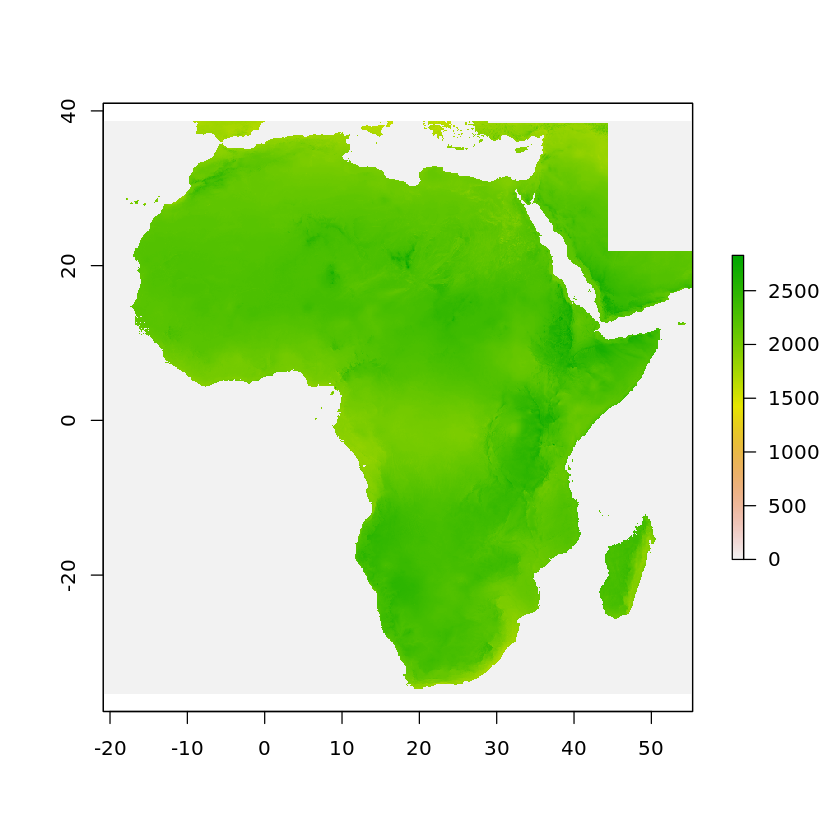

In [6]:
solar <- raster('../data/africa/solar.tif')
land_cover <- raster('../data/africa/land_cover.tif')
elevation <- raster('../data/africa/elevation.tif')

plot(solar)

<br>

### Raster Pre-Processing

In the same way you can clip vectors with a “cookie cutter” outline you can also clip rasters. 

`crop` allows us to clip the raster to the extents of the vector geometry, similar to cropping an image.

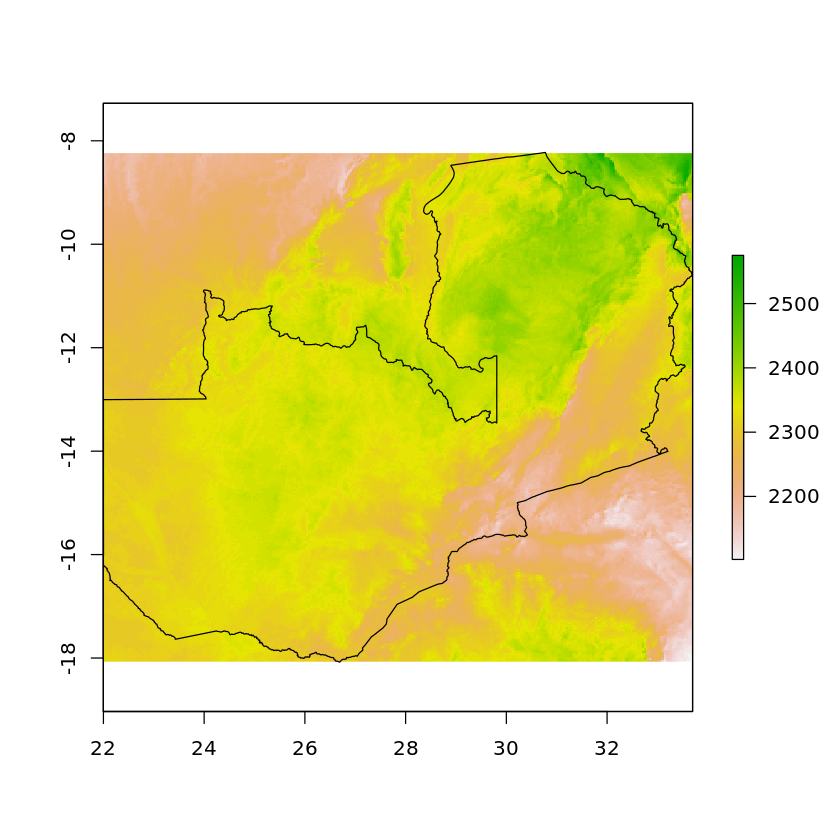

In [7]:
df_zambia_4326 <- st_transform(df_zambia, crs=st_crs(solar))
solar_zambia <- crop(solar, df_zambia_4326)

plot(solar_zambia)
plot(df_zambia_4326['geometry'], add=TRUE)

<br>

If we want to remove all values that are outside of Zambia's borders we can use `mask`

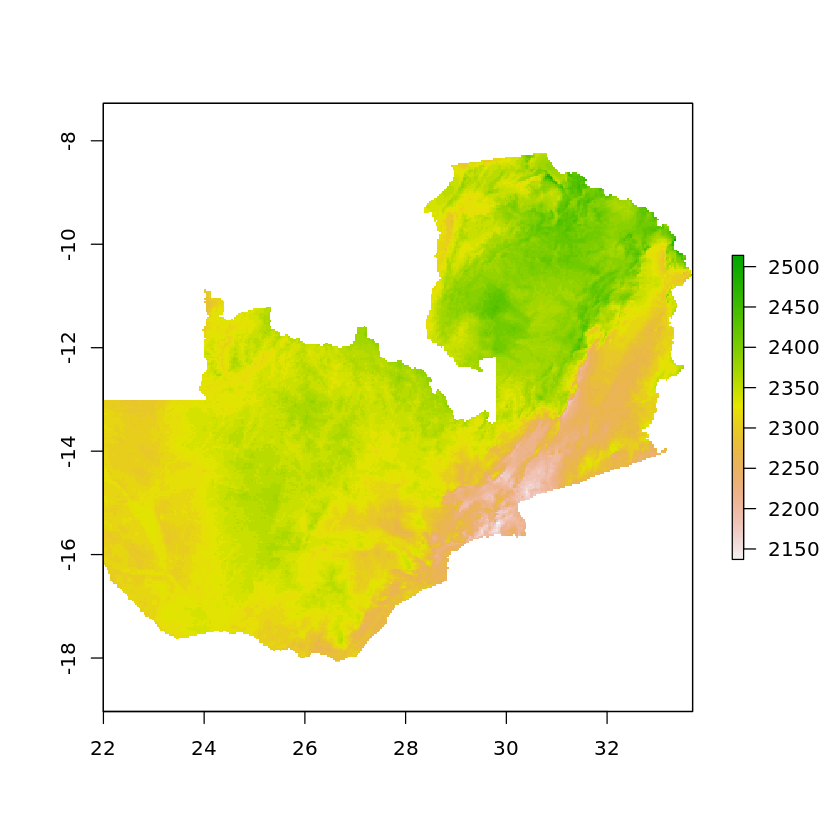

In [10]:
masked_solar_zambia <- mask(solar_zambia, df_zambia_4326)

plot(masked_solar_zambia)

<br>



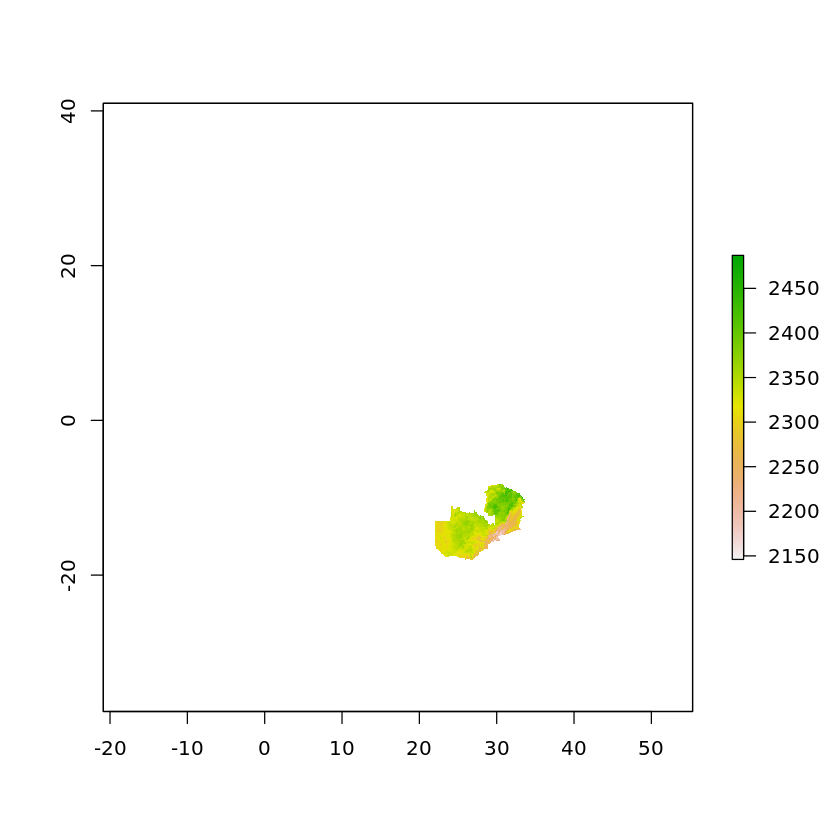

In [11]:
plot(mask(solar, df_zambia_4326))

<br>

Whilst the existing mask function is really useful it doesn't give us all of the fine-grained control we might require. For example a common area for fine-tuning raster masks is deciding the cut-off point for when cells are inside/outside the border - should we include all cells that the border touches or only the ones that fall fully inside it?

To enable this flexibility we'll create our own raster mask. 

First we'll rasterize the zambia polygon, passing an example raster which will be used to construct the grid, as well as the optional argument `getCover`. By setting `getCover` to `TRUE` the values of the returned raster will be the percentage of the cell that falls inside the polygon. We'll also set all cells that do not touch the polygon to `NA`.

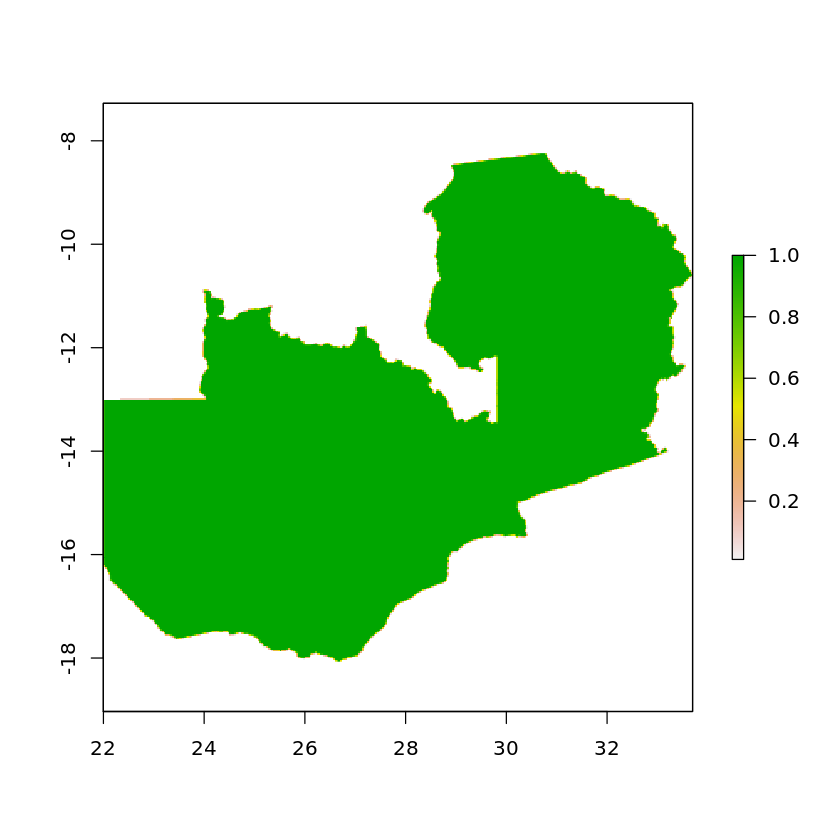

In [18]:
zambia_raster <- rasterize(df_zambia_4326, solar_zambia, getCover=TRUE)
zambia_raster[zambia_raster==0] <- NA

plot(zambia_raster) 

<br>

For plotting with Ggplot, we'll convert our raster into a tibble and also remove any `NA` values.

In [53]:
tb_zambia_raster <- gplot_data(zambia_raster)
tb_zambia_raster <- subset(tb_zambia_raster, !is.na(tb_zambia_raster$value))

head(tb_zambia_raster)

x,y,value,variable
<dbl>,<dbl>,<dbl>,<chr>
30.44767,-8.262019,0.09,layer
30.49581,-8.262019,0.19,layer
30.54396,-8.262019,0.34,layer
30.59210,-8.262019,0.58,layer
30.64025,-8.262019,0.73,layer
30.68840,-8.262019,0.97,layer


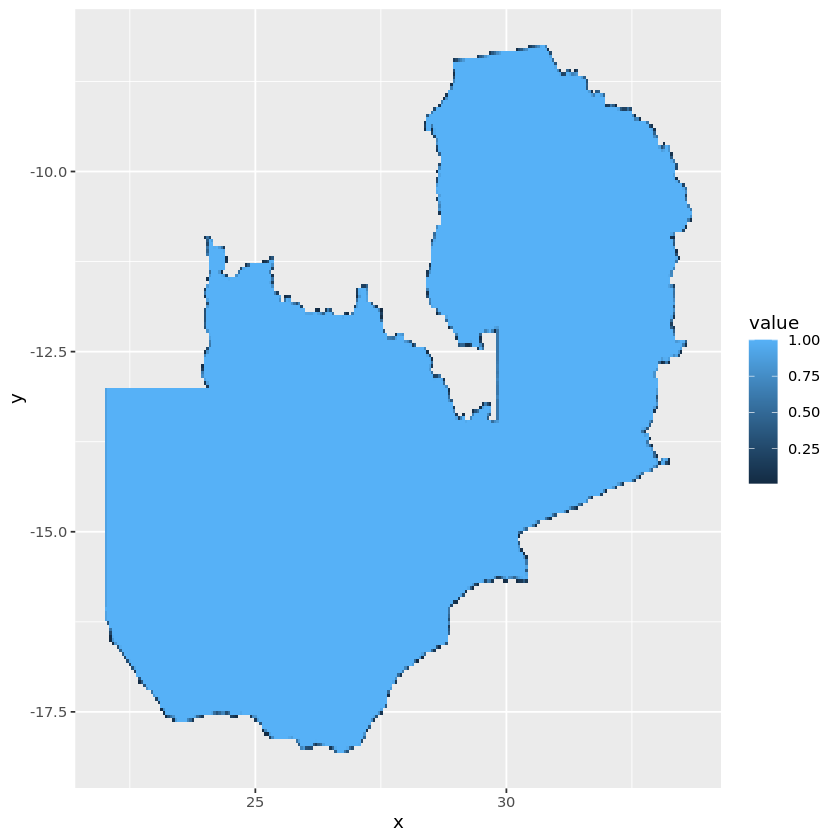

In [54]:
ggplot() +
    geom_tile(data=tb_zambia_raster, aes(x=x, y=y, fill=value)) + 
    geom_sf(data=df_zambia_4326, fill='orange') +
    coord_sf(xlim=c(28, 30), 
             ylim=c(-13.5, -11.75))